# Functions

In [ ]:
from tcc_markov_chain.base_simulation import Simulation
from tcc_markov_chain.simulations import MarkovChain, PeriodicDirectSampling
from typing import List
from tcc_markov_chain.systems import HDPeriodic
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

# Functions

In [ ]:
def particle_density(sim:Simulation, strip_count = 10)->List[float]:
    strip_size = sim.system.box_size / strip_count
    strips = np.arange(strip_count) * strip_size
    strip_contribution = []
    for strip in strips:
        is_inside = (sim.system.positions[:,1] >= strip) * (sim.system.positions[:,1] < strip + strip_size)
        factor = np.sum(is_inside)
        strip_contribution.append(factor)
    # sim.strip_density += strip_contribution
    return strip_contribution

In [ ]:
def rdf(sim:Simulation, n_bins=10):
    distances = sim.sys._get_relative_positions()
    distances = np.linalg.norm(distances,axis=1)
    bin_size = sim.sys.box_size / n_bins
    bins =np.linspace(0, sim.sys.box_size/2, n_bins + 1)
    for d in distances:
        bins[int(d//bin_size)]+=2
    return bins

# Main

## Particle density - DirectSampling

In [13]:
box_size=10
n_particles=4
particle_radius=1
n_steps=int(1e4)

sys = HDPeriodic(box_size=box_size,particle_radius=particle_radius,n_particles=n_particles)
sim = PeriodicDirectSampling(sys)
direct_sampling_run = sim.run(
    eval_fn=lambda x: particle_density(x,strip_count),
    n_steps=n_steps
)

strip_count=500
strip_size = box_size /strip_count
strip_density = np.arange(strip_count) * 0.
for step in direct_sampling_run:
    strip_density+=step
strip_density /= (n_steps*strip_size)

2025-07-15 18:39:20,598 - INFO - creting system with 4 particles of radii 1
2025-07-15 18:39:20,599 - INFO - density: 0.12566370614359174, box size 10
2025-07-15 18:39:20,601 - INFO - system created
100%|██████████| 10000/10000 [00:19<00:00, 504.81it/s]


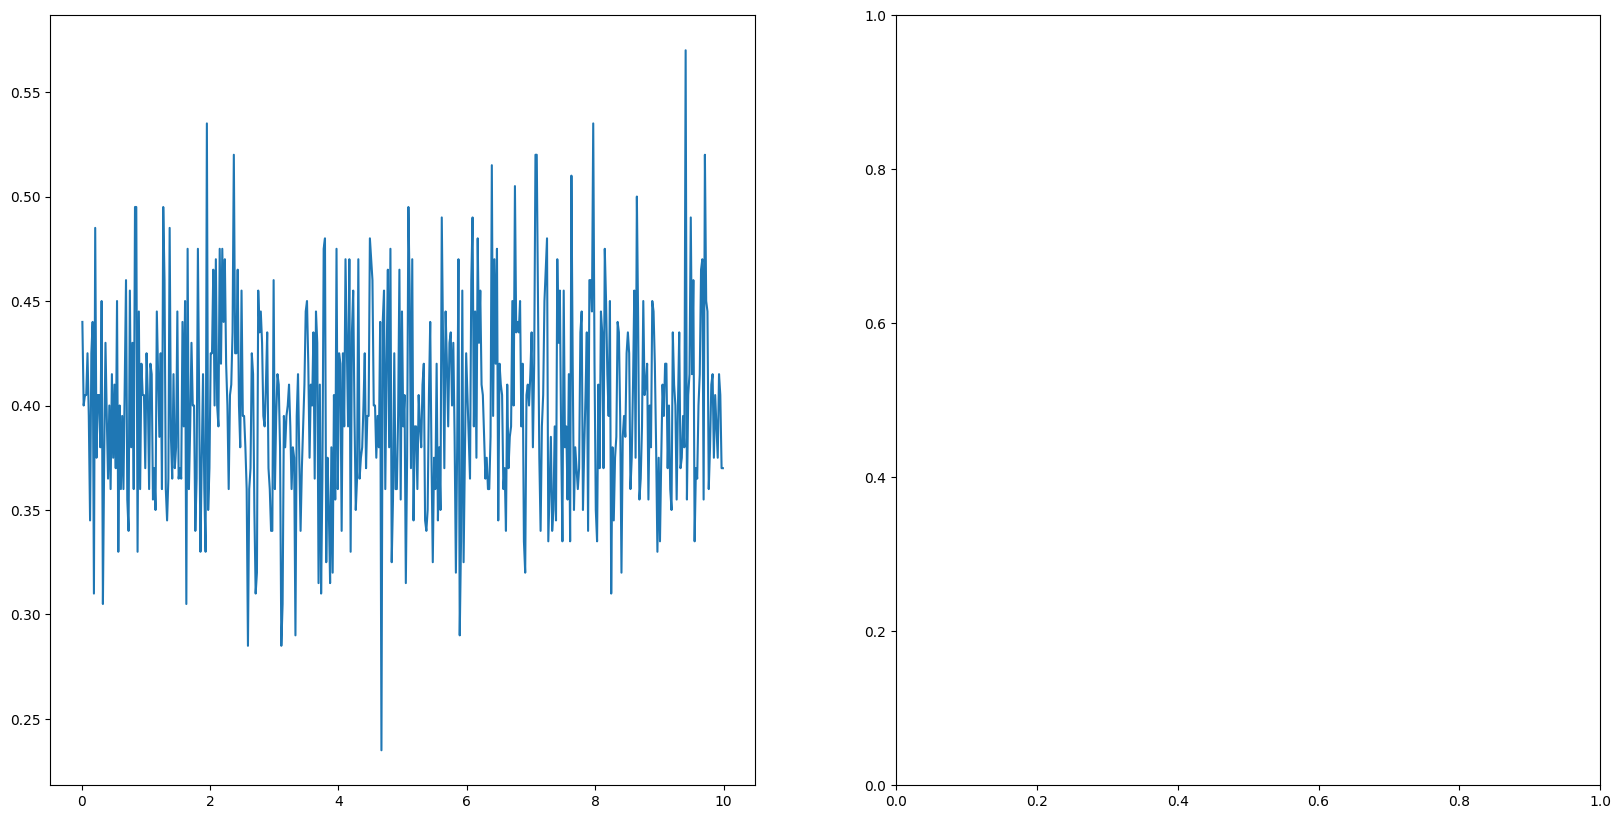

In [15]:
strip_centers = (np.arange(strip_count) * strip_size) + (strip_size / 2)
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].plot(strip_centers, strip_density, linestyle='-')
# axes[1].plot(strip_centers, sim_big_system.strip_density, linestyle='-')

## Markov Chain

2025-07-15 18:41:35,162 - INFO - creting system with 64 particles of radii 0.4
2025-07-15 18:41:35,163 - INFO - density: 0.32169908772759487, box size 10
2025-07-15 18:41:35,176 - INFO - system created
100%|██████████| 100000/100000 [00:47<00:00, 2097.31it/s]


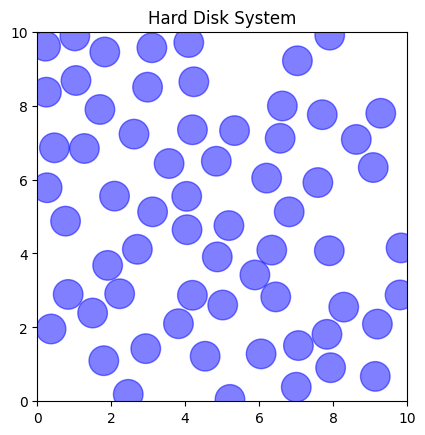

In [17]:
box_size = 10
particle_radius=0.4
n_particles=64
n_steps = int(1e5)
sys = HDPeriodic(box_size=10, particle_radius=particle_radius, n_particles=n_particles)
sim_mc = MarkovChain(system=deepcopy(sys),delta_x=particle_radius/2)
# sim_mc.system.plot_system()

strip_count=int(100)
strip_size = sim_mc.system.box_size / strip_count
strip_density = np.zeros(strip_count,dtype=float)
for step in sim_mc.run(eval_fn=lambda x: particle_density(x,strip_count=strip_count),n_steps=n_steps):
    strip_density+=step
strip_density /= (n_steps*strip_size)
# print(strip_density / (n_steps*strip_size))
sim_mc.system.plot_system()

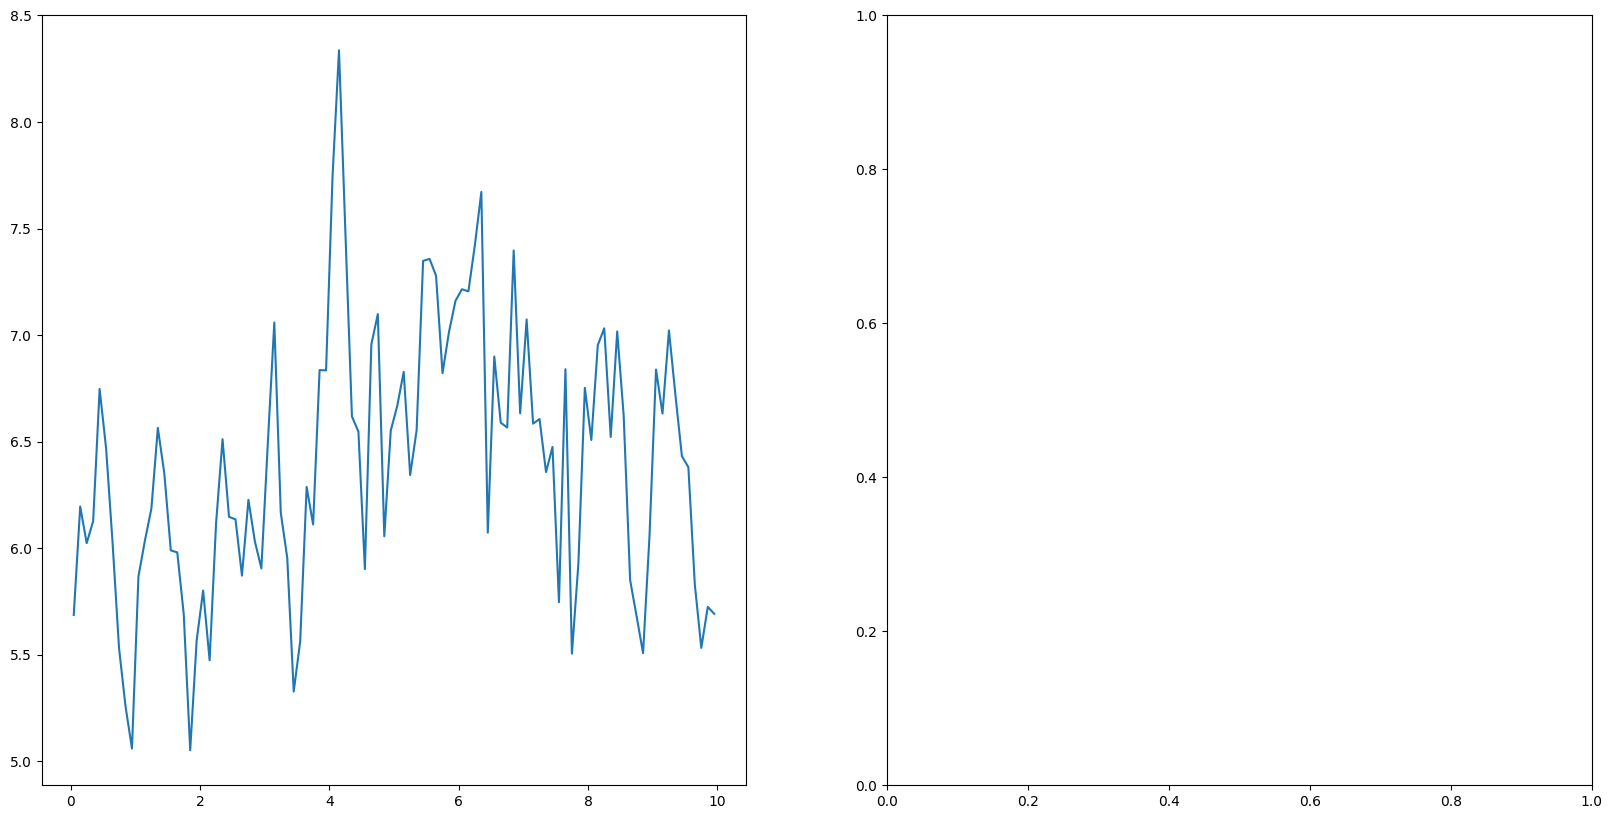

In [18]:
strip_centers = (np.arange(strip_count) * strip_size) + (strip_size / 2)
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].plot(strip_centers, strip_density, linestyle='-')

### Phase transition

2025-07-15 01:32:02,948 - INFO - creting system with 20 particles of radii 0.6 and box size 10
2025-07-15 01:32:02,950 - INFO - density: 0.2261946710584651
2025-07-15 01:32:02,952 - INFO - system created
Simulating: 100%|██████████| 100000/100000 [00:08<00:00, 12110.87frame/s]


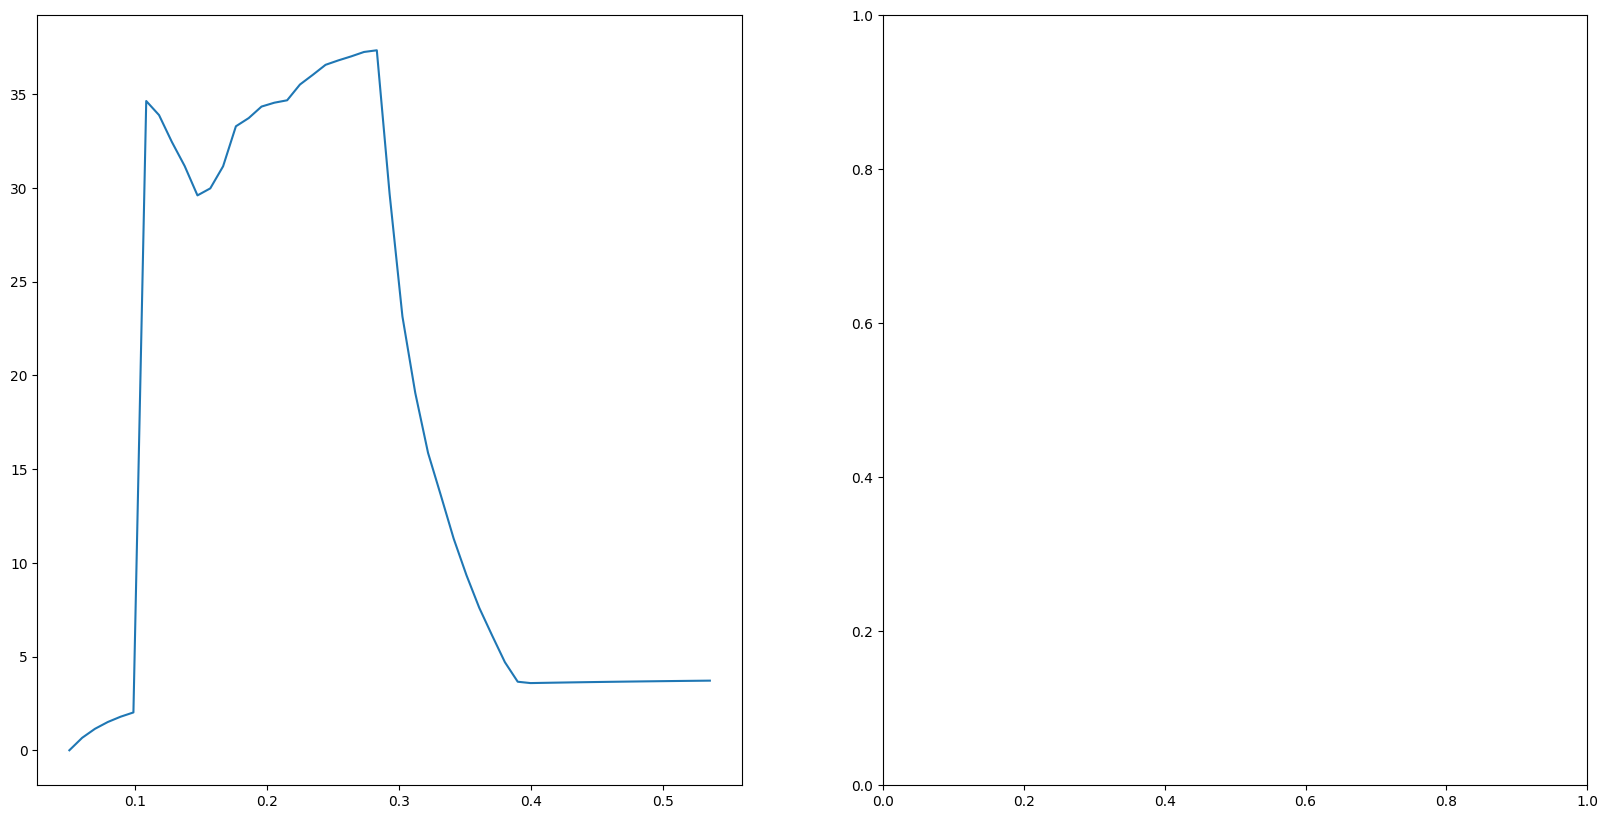

In [19]:
box_size = 10
particle_radius=0.6
n_particles=20
n_steps = int(1e5)
n_bins=int(50)

sys = HardDiskSystem(box_size=box_size, particle_radius=particle_radius, n_particles=n_particles)
sim_mc = MarkovChain(system=deepcopy(sys),delta_x=particle_radius/2)

bin_size = sim_mc.sys.box_size / (2*n_bins)
bins = np.linspace(0, sim.sys.box_size/2, n_bins + 1)
for step in sim_mc.run(eval_fn=lambda x: rdf(x,n_bins=n_bins),n_steps=n_steps):
    bins+=step

#ploting
density = n_particles / (box_size ** 2)
bins_centers = (np.linspace(0, sim.sys.box_size/2, n_bins + 1) * bin_size) + (bin_size / 2)
bins_normalization = (2 * np.pi * bins_centers * bin_size * density * n_particles * n_steps)
bins /= bins_normalization
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].plot(bins_centers, bins, linestyle='-')